In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import h5py
#in-house functions for directed actflow analysis
import pseudoEmpiricalData
import featureSelectRegression
import PCalg_wrapper #to call the PC algorithm Java package
import CombinedFC.CombinedFCToolBox as cfc #repo: https://github.com/ColeLab/CombinedFC
import ActflowToolbox as actflow #info: https://colelab.github.io/ActflowToolbox/

### download empirical data for the pseudo-empirical simulated fMRI

In [2]:
data_dir = f'{os.getcwd()}/hcp_data' 

# hcp subjects by ID: 176 subjects
# Datasets contain for each subject: 
# - one session resting-state bold [360 regions x 1195 datapoints]
# - 24 task conditions activations [360 regions x 24 conditions]
# 360 regions are from the Glasser et al. (2016) parcellation

hcp_cohort = ['100206','108020','117930','126325','133928','143224','153934','164636','174437',
            '183034','194443','204521','212823','268749','322224','385450','463040','529953',
            '587664','656253','731140','814548','877269','978578','100408','108222','118124',
            '126426','134021','144832','154229','164939','175338','185139','194645','204622',
            '213017','268850','329844','389357','467351','530635','588565','657659','737960',
            '816653','878877','987074','101006','110007','118225','127933','134324','146331',
            '154532','165638','175742','185341','195445','205119','213421','274542','341834',
            '393247','479762','545345','597869','664757','742549','820745','887373','989987',
            '102311','111009','118831','128632','135528','146432','154936','167036','176441',
            '186141','196144','205725','213522','285345','342129','394956','480141','552241',
            '598568','671855','744553','826454','896879','990366','102513','112516','118932',
            '129028','135629','146533','156031','167440','176845','187850','196346','205826',
            '214423','285446','348545','395756','481042','553344','599671','675661','749058',
            '832651','899885','991267','102614','112920','119126','129129','135932','147636',
            '157336','168745','177645','188145','198350','208226','214726','286347','349244',
            '406432','486759','555651','604537','679568','749361','835657','901442','992774',
            '103111','113316','120212','130013','136227','148133','157437','169545','178748',
            '188549','198451','208327','217429','290136','352738','414229','497865','559457',
            '615744','679770','753150','837560','907656','993675','103414','113619','120414',
            '130114','136833','150726','157942','171330']

num_subjects = len(hcp_cohort)
# initialize an array to save subjects data
rest_data = np.empty((360,1195,num_subjects))
for s in range(num_subjects):
    # read the h5 files from the hcp_data directory
    hf = h5py.File(f'{data_dir}/hcp_{hcp_cohort[s]}_rsBold_taskActivations.h5', 'r')
    # save the files in a numpy array
    rest_data[:,:,s] = hf.get('rest_bold')
    
# rest_data is going to be used for pseudo-empirical simulated fMRI data

### define parameters for the simulated networks + data

In [3]:
# import the graphModel module from the CombinedFCToolBox
from CombinedFC.CombinedFCToolBox import graphModel

# number of repetitions of the simulation
num_repetitions = 200

# graphical model parameters
num_nodes = 200
density_edges = 0.05
model_type = 'ErdosRenyi'
# round and make an int (multiply by 2 because the model reduce the original density by half)
num_edges = np.around(density_edges*2*(num_nodes*(num_nodes-1)/2)).astype(int)
# number of datapoints for the simulated data
sample_size = 1000
# coefficients for the weights of the connectivity matrix
min_coeff = 0.1
max_coeff = 0.4
# percentage of negative coefficients
p_neg = 0.10

# number of tasks to simulate
num_tasks = 1
# percentage of nodes directly affected by the task: T --> node_i
p_nodes = 0.10
# number of nodes directly affected by the task for this model
Nt = np.around(p_nodes*num_nodes).astype(int)

# add cycles
# percentage of connections that are also 2-cycles
p_2cycles = 0.30
# 3-cycles as a percentage of the number of nodes
p_3cycles = 0.20
num_3cycles = np.round(p_3cycles*num_nodes).astype(int)


print('Main parameters of the simulations')
print(f'- number of simulations: {num_repetitions}')
print(f'- number of nodes: {num_nodes}')
print(f'- connectivity density: {density_edges*100}%')
print(f'- edge coefficient range (-{max_coeff},-{min_coeff}]U({min_coeff},{max_coeff}]')
print(f'- percentage of negative edges: {p_neg*100}%')
print(f'- percentage of edges that are two-node cycle: {p_2cycles*100}%')
print(f'- aprox. number of three-node cycles: {num_3cycles}')
print(f'- tasks simulated: {num_tasks} per simulation')
print(f'- precentage of nodes directly affected by the task: {p_nodes*100}%')
print(f'- number of datapoints: {sample_size}')

Main parameters of the simulations
- number of simulations: 200
- number of nodes: 200
- connectivity density: 5.0%
- edge coefficient range (-0.4,-0.1]U(0.1,0.4]
- percentage of negative edges: 10.0%
- percentage of edges that are two-node cycle: 30.0%
- aprox. number of three-node cycles: 40
- tasks simulated: 1 per simulation
- precentage of nodes directly affected by the task: 10.0%
- number of datapoints: 1000


### simulate data: resting-state, task-state and actual task activations

In [4]:
%%time
# simulate data: resting-state, task-state and actual task activations

# initialize vectors to save true network models and pseudoempirical data
# each repetition can be thought as one resting-state and task-state session (may contain more than one task)
X_rest = np.empty((num_nodes,sample_size,num_repetitions))
W_rest = np.empty((num_nodes,num_nodes,num_repetitions))
# task state data has the additional dimension of number of tasks
# need to add 1 for the task variable data and for the task connectivity vector
X_task = np.empty((num_nodes+1,sample_size,num_tasks,num_repetitions))
W_task = np.empty((num_nodes+1,num_nodes+1,num_tasks,num_repetitions))
# actual activations
actual_act = np.zeros((num_nodes,num_tasks,num_repetitions))


for rep in range(num_repetitions):
    # 1. Generate the true connectivity network, using the model_type graph model defined above
    # M is a binary directed network M[ij]: node_j --> node_i
    M = graphModel.graphModel(model_type, num_edges, num_nodes)
    
    # add two-node cycles to the M network: node_i -> node_j & node_j -> node_i
    e = np.where(M==1)
    list_edges = np.array([e[0],e[1]])
    actual_numEdges = list_edges.shape[1]
    # randomly define the two-node cycles from the list of edges
    idx = np.random.choice(np.arange(actual_numEdges),np.round(p_2cycles*actual_numEdges).astype(int),
                           replace=False)
    # add an opposite direction edge to form the two-node cycle
    M[list_edges[1,idx],list_edges[0,idx]] = 1

    # get the triple of nodes to turn into three-node cycles
    # initial random nodes
    init_nodes = np.random.choice(np.arange(0,num_nodes-2),num_3cycles,replace=False)
    # form the three-node cycle: node_i -> node_j -> node_k -> node_i
    for i in init_nodes:
        for j in range(i+1,num_nodes-1):
            if M[j,i] == 1 and M[i,j] == 0:
                for k in range(j+1,num_nodes):
                    if M[k,j] == 1 and M[j,k] == 0 and M[k,i] == 0:
                        M[i,k] = 1
                        break
                break

    # remove accidentally nested three-node cycles
    # for example, i->j->k->i and i->m->k->i
    n = 0
    triples = [[100000,0,0]]  #just a large number for the 1st comparison
    for i in range(0,num_nodes-2):
        for j in range(i+1,num_nodes-1):
            for k in range(j+1,num_nodes):
                # identify three-node cycle: node_i -> node_j -> node_k -> node_i
                if M[j,i] == 1 and M[i,j] == 0 and M[k,j] == 1 and M[j,k] == 0 and M[k,i] == 0 and M[i,k] == 1:
                    # append to list
                    triples.append([i,j,k])
                    n = n + 1
                    # if nested, remove the three-node cycle from the list
                    if triples[n][0] == triples[n-1][0]:
                        M[j,i] = 0

    # 2. Simulate resting-state connectivity and pseudo-empirical data
    # randomly choose an empirical subject from which to sample the data
    subj_data = np.random.choice(num_subjects,1,replace=True)[0]
    # transpose it to [datapoints x nodes]
    data_hcp = rest_data[:,:,subj_data].T
    # simulate resting state data X and weighted connectivity matrix W,
    # using the pseudoEmpirical_data function
    X_rest[:,:,rep], W_rest[:,:,rep] = pseudoEmpiricalData.pseudoEmpiricalData(data = data_hcp, 
                                                               model = M, 
                                                               sample_size = sample_size,
                                                               weights_given = False, 
                                                               min_coeff = min_coeff, 
                                                               max_coeff = max_coeff, 
                                                               p_neg = p_neg)
    
    
    # 3. Simulate task-state connectivity. One loop for each task
    for j in range(num_tasks):
        # initialize the new task matrix coefficents with a copy of the rest network
        M_task = W_rest[:,:,rep].copy()
        # compute the number of edges of the task connectivity matrix
        num_edges_task = np.sum(M_task != 0) 
        # define the task network based on the resting-state network
        # with some random variance added to the coefficients.
        # add some variability to the coefficients so they do not end up being exactly the same as W_rest
        # by summing or subtracting one standard deviation to the coefficient, or doing nothing.
        std_coeff = np.std(M_task[M_task > 0].flatten())
        # make a vector to randomly decide if std_coeff should be added, subtracted or do nothing
        aux_vec = np.random.choice([+std_coeff,-std_coeff,0],size=(1,num_edges_task))
        # create a new vector with the modfied values
        task_weights = M_task[M_task.nonzero()] + aux_vec
        # assign the new values to their position in M_task
        M_task[M_task.nonzero()] =  task_weights
        
        # 4. Add the Task connectivity vector: which nodes are affected by the task variable
        # sample Nt nodes from a num_nodes elements vector, without replacement to avoid choosing a node more than once
        task_nodes = np.random.choice(np.arange(num_nodes),size=[1,Nt],replace=False)
        # build the Task connectivity vector T
        T = np.zeros((num_nodes,1))
        # and assign a task-coefficient to the nodes affected by the task
        T[task_nodes,0] = np.random.uniform(min_coeff,max_coeff, size=(1,Nt))
        # add the T vector to the nodes connectivity matrix M_task
        M_task = np.concatenate((M_task,T),axis=1)
        # add a last row of zeros to make the matrix square
        pad = np.zeros((1,num_nodes+1))
        M_task = np.concatenate((M_task,pad), axis=0)
        
        #5. Create pseudo-empirical task-state data
        # use the same subject empirical data
        # simulate task data X and task connectivity matrix W, using the pseudo_data function
        X_task[:,:,j,rep], W_task[:,:,j,rep] = pseudoEmpiricalData.pseudoEmpiricalData(data = data_hcp, 
                                                                   model = M_task, 
                                                                   sample_size = sample_size, 
                                                                   weights_given = True)
        
        
        # 6. compute the task activations using a GLM
        data = X_task[:,:,j,rep].copy() #reshape to [datapoints x nodes]
        for i in range(num_nodes):
            # regress each node onto the task: task causal effect
            # use reshape to convert 1D to proper 2D arrays for linear regression call
            y = np.reshape(data[i,:],(-1,1))
            # the task variable data is the last element of the data = X_task
            task = np.reshape(data[-1,:],(-1,1))
            # use the combinedFC toolbox function for regression
            # no significance test threshold, use all the values.
            b = cfc.simpleRegressionSig(y, task, sigTest = False)
            # save the actual activations values [nodes x task x repetition]
            actual_act[i,j,rep] = b
            
print('- resting state data (X_rest) and actual activations (actual_act) created')
print('- the true resting-state network models are in W_rest')
print(f'- for {num_tasks} task(s) and {num_repetitions} simulations')

- resting state data (X_rest) and actual activations (actual_act) created
- the true resting-state network models are in W_rest
- for 1 task(s) and 200 simulations
CPU times: user 2min 54s, sys: 833 ms, total: 2min 55s
Wall time: 1min 58s


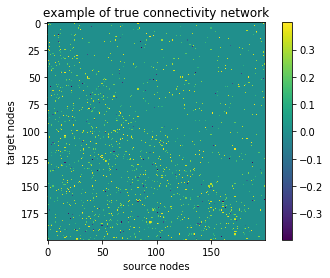

In [6]:
plt.imshow(W_rest[:,:,0])
plt.colorbar()
plt.title('example of true connectivity network')
plt.xlabel('source nodes')
plt.ylabel('target nodes')
plt.show()

### Functional connectivity (FC) analysis + Activity flow predictions

### correlation

In [7]:
%%time
# correlation analysis of the resting-state data X_rest using combinedFC toolbox
m_corr = np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_corr = np.empty((num_nodes,num_tasks,num_repetitions))
time_corr = np.empty((num_repetitions,))

for rep in range(num_repetitions):
    start = time.time()
    # FC computation
    m_corr[:,:,rep] = cfc.correlationSig(X_rest[:,:,rep].T, alpha = 0.01)
    
    # activity flow calculation using activity flow toolbox
    for j in range(num_tasks):
        pred_act_corr[:,j,rep] = actflow.actflowcalc(actual_act[:,j,rep], m_corr[:,:,rep])
    
    # save running time
    time_corr[rep] = time.time() - start

print('- correlation FC matrices and activity flow predictions')
print(f'- for {num_tasks} task(s) and {num_repetitions} simulations')

- correlation FC matrices and activity flow predictions
- for 1 task(s) and 200 simulations
CPU times: user 4.59 s, sys: 40.3 ms, total: 4.63 s
Wall time: 2.36 s


### multiple regression

In [ ]:
%%time
# multiple regression analysis of the resting-state data X_rest using combinedFC toolbox
m_mreg = np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_mreg = np.empty((num_nodes,num_tasks,num_repetitions))
time_mreg = np.empty((num_repetitions,))

for rep in range(num_repetitions):
    start = time.time()
    # FC computation
    m_mreg[:,:,rep] = cfc.multipleRegressionSig(X_rest[:,:,rep].T, alpha = 0.01, sigTest = True)
    
    # activity flow calculation using activity flow toolbox
    for j in range(num_tasks):
        pred_act_mreg[:,j,rep] = actflow.actflowcalc(actual_act[:,j,rep], m_mreg[:,:,rep])
    
    # save running time
    time_mreg[rep] = time.time() - start

print('- multiple regression FC matrices and activity flow predictions')
print(f'- for {num_tasks} task(s) and {num_repetitions} simulations')

### combinedFC

In [27]:
%%time
# combinedFC with feature selection analysis of resting-state data X_rest
m_cfc =  np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_cfc = np.empty((num_nodes,num_tasks,num_repetitions))
time_cfc = np.empty((num_repetitions,))

for rep in range(num_repetitions):
    start = time.time()
    # FC computation
    data = X_rest[:,:,rep].T
    M_aux = cfc.combinedFC(data,
                         methodCondAsso = 'partialCorrelation',
                         alphaCondAsso = 0.01,
                         methodAsso = 'correlation',
                         alphaAsso = 0.01)
    
    m_cfc[:,:,rep] = featureSelectRegression.featureSelectRegression(M_aux, data, typ='symmetric')
    
    # activity flow calculation using activity flow toolbox    
    for j in range(num_tasks):
        pred_act_cfc[:,j,rep] = actflow.actflowcalc(actual_act[:,j,rep], m_cfc[:,:,rep])
    
    # save running time
    time_cfc[rep] = time.time() - start
     
print('- combinedFC FC matrices and activity flow predictions')
print(f'- for {num_tasks} task(s) and {num_repetitions} simulations')

- combinedFC FC matrices and activity flow predictions
- for 1 task(s) and 200 simulations
CPU times: user 1min 8s, sys: 366 ms, total: 1min 8s
Wall time: 35.2 s


### PC algorithm and PC-adjacencies

In [ ]:
%%time
# PC algorithm FC analysis of resting-state data X_rest
m_PC =  np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_PC = np.empty((num_nodes,num_tasks,num_repetitions))
time_PC = np.empty((num_repetitions,))
# PC-adjacencies
m_PCadj =  np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_PCadj = np.empty((num_nodes,num_tasks,num_repetitions))
time_PCadj = np.empty((num_repetitions,))

current_dir = os.getcwd()

# large continuous runs may "stuck" Tetrad (not clear why)
# a cheap solution is to run the repetitions in batches

batches = np.arange(0,num_repetitions,4)
rep = 0
for bat in range(len(batches)):
    for a in range(batches[bat],batches[bat]+4):
        startPC = time.time()
        # FC computation
        # temporary save data for PC. The algorithm requires a txt file as input
        data = X_rest[:,:,rep].T
        # reuse the same name to avoid ending up with too many txt files
        inputData = f'{current_dir}/temp/data_temp.txt'
        np.savetxt(inputData, data, fmt='%0.6f', delimiter=',')
        # define output directory, output file name and Tetrad software path
        outDir = f'{current_dir}/temp'
        outName = 'PCgraph_temp'
        tetrad_path = f'{current_dir}/tetrad_causal-cmd-1.1.3/causal-cmd-1.1.3-jar-noMeekRules234.jar'
        # call PC
        PCalg_wrapper.PCalg_run(inputData, outDir, outName, tetrad_path, alpha = 0.01)
        # transform the PC output graph into a numpy array
        PC_graph = PCalg_wrapper.tetrad2matrix(f'{outDir}/{outName}.txt')
        time_search_PC = time.time() - startPC
        print(f'graph {rep}')

        # Use the set of parents as regressors y = bPa(X) + e, to get a weighted directed matrix
        # refer as PC or PC algorithm in the paper
        start = time.time()
        m_PC[:,:,rep] = featureSelectRegression.featureSelectRegression(PC_graph, data, typ='parents')
        # activity flow calculation using activity flow toolbox
        for j in range(num_tasks):
            pred_act_PC[:,j,rep] = actflow.actflowcalc(actual_act[:,j,rep], m_PC[:,:,rep])
        # running time is the PC search time + computation of weights time + actflowcalc    
        time_PC[rep] = (time.time() - start) + time_search_PC

        # Use the adjacencies of the PC results: parents and children: y = bPa(X) + cCh(x),
        # refer as PCadj or PC adjacencies, in the paper
        start = time.time()
        m_PCadj[:,:,rep] = featureSelectRegression.featureSelectRegression(PC_graph, data, typ='adjacencies')
        
        # activity flow calculation using activity flow toolbox
        for j in range(num_tasks): 
            pred_act_PCadj[:,j,rep] = actflow.actflowcalc(actual_act[:,j,rep], m_PCadj[:,:,rep])
        time_PCadj[rep] = (time.time() - start) + time_search_PC
    
        rep = rep + 1
        
print('- PC and PC-adjacencies FC matrices and activity flow predictions')
print(f'- for {num_tasks} task(s) and {num_repetitions} simulations')

### plot adjacency network recovery results

In [ ]:
#compute goodness of recovery of true resting-state networks
#use precision and recall as measures. See Figure 2 in paper for details
#use precision and recall functions from the combinedFC toolbox
def accuracy_connectivity(inferred_model, true_model):
    ''''
    both input arrays should be dim:[num_nodes x num_nodes x num_repetitions]
    '''
    # get the number of repetitions. it should be the 3rd dimension of inferred_model
    num_repetitions = inferred_model.shape[2]
    # initialize arrays for results
    precision = np.empty((num_repetitions))
    recall = np.empty((num_repetitions))
    
    for rep in range(num_repetitions):
        # precision = true positives / [true positives + false positives]
        precision[rep] = cfc.precision(inferred_model[:,:,rep], true_model[:,:,rep])
        # recall = true positives / [true positives + false negatives]
        recall[rep] = cfc.recall(inferred_model[:,:,rep], true_model[:,:,rep])
    return precision, recall

In [ ]:
#call the accuracy computation function for each FC method tested
#W_rest contains the true resting-state connectivity matrices
corr_precision, corr_recall = accuracy_connectivity(m_corr, W_rest)  
mreg_precision, mreg_recall = accuracy_connectivity(m_mreg, W_rest)  
cfc_precision, cfc_recall = accuracy_connectivity(m_cfc, W_rest)  
PC_precision, PC_recall = accuracy_connectivity(m_PC, W_rest)  
PCadj_precision, PCadj_recall = accuracy_connectivity(m_PCadj,W_rest)  

#consolidate precision results for bar plotting
results_precision = [corr_precision, mreg_precision, cfc_precision, PCadj_precision, PC_precision]
#print median precision across repetitions for each method
print(f'median precision across {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_precision):.4f}')
print(f' mul.reg       : {np.median(mreg_precision):.4f}')
print(f' combinedFC    : {np.median(cfc_precision):.4f}')
print(f' PC-adjacencies: {np.median(PCadj_precision):.4f}')
print(f' PC algorithm  : {np.median(PC_precision):.4f}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_precision,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Network recovery: Precision',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylim(0,1)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
plt.show()
# uncomment to save the plot as a pdf file 
#plt.savefig('SimulationPrecision.pdf',bbox_inches='tight')


#consolidate recall results
results_recall = [corr_recall, mreg_recall, cfc_recall,PCadj_recall,PC_recall]
#print median recall across across repetitions for each method
print(f'median recall across {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_recall):.4f}')
print(f' mul.reg       : {np.median(mreg_recall):.4f}')
print(f' combinedFC    : {np.median(cfc_recall):.4f}')
print(f' PC-adjacencies: {np.median(PCadj_recall):.4f}')
print(f' PC algorithm  : {np.median(PC_recall):.4f}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_recall,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Network recovery: Recall',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylim(0,1)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
plt.show()
# uncomment to save the plot as a pdf file
#plt.savefig('SimulationRecall.pdf',bbox_inches='tight')

### compute prediction accuracy of the actflow models parameterized with the different FC methods

In [28]:
# Output measures: Pearson correlation / R^2 coefficient of determination // MAE mean absolute error
# dict_keys(['corr_vals', 'R2_vals', 'mae_vals'])
# For each of the accuracy metrics the output is a 2D list: task conditions x number of simulations

# compute prediction accuracy of an activity flow model
# Input is a 3D activation array: node x task x repetition
# computes the accuracy individually for each task  across nodes, per repetition
corr_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = actual_act,
                                          pred_actvect = pred_act_corr,
                                          comparison_type = 'nodewise_compthenavg'
                                          )

cfc_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = actual_act,
                                          pred_actvect = pred_act_cfc,
                                          comparison_type = 'nodewise_compthenavg'
                                          )

In [ ]:
mreg_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = actual_act,
                                          pred_actvect = pred_act_mreg,
                                          comparison_type = 'nodewise_compthenavg'
                                          )

cfc_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = actual_act,
                                          pred_actvect = pred_act_cfc,
                                          comparison_type = 'nodewise_compthenavg'
                                          )

PCadj_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = actual_act,
                                          pred_actvect = pred_act_PCadj,
                                          comparison_type = 'nodewise_compthenavg'
                                          )

PC_acc = actflow.model_compare_predicted_to_actual(
                                          target_actvect = actual_act,
                                          pred_actvect = pred_act_PC,
                                          comparison_type = 'nodewise_compthenavg'
                                          )

### plot activity flow accuracy prediction

In [ ]:
# Accuracies are first averaged across tasks
# choose Pearson r as accuracy metric: options: ['corr_vals', 'R2_vals', 'mae_vals']
corr_acc_conditionAvg = np.mean(corr_acc['corr_vals'],axis=0)
mreg_acc_conditionAvg = np.mean(mreg_acc['corr_vals'],axis=0)
cfc_acc_conditionAvg = np.mean(cfc_acc['corr_vals'],axis=0)
PCadj_acc_conditionAvg = np.mean(PCadj_acc['corr_vals'],axis=0)
PC_acc_conditionAvg = np.mean(PC_acc['corr_vals'],axis=0)

# consolidate results for bar plotting
results_prediction = [corr_acc_conditionAvg,
                      mreg_acc_conditionAvg,
                      cfc_acc_conditionAvg,
                      PCadj_acc_conditionAvg,
                      PC_acc_conditionAvg]
# print median precision across subjects for each method
print(f'nodewise median prediction accuracy (r) across {num_tasks} tasks and {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_acc_conditionAvg):.4f}')
print(f' mul.reg       : {np.median(mreg_acc_conditionAvg):.4f}')
print(f' combinedFC    : {np.median(cfc_acc_conditionAvg):.4f}')
print(f' PC-adjacencies: {np.median(PCadj_acc_conditionAvg):.4f}')
print(f' PC algorithm  : {np.median(PC_acc_conditionAvg):.4f}')
# plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_prediction,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Actflow prediction accuracy', fontsize=20)
plt.ylabel('Pearson r',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylim(0,1)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('SimulationPredictionAccuracy.pdf',bbox_inches='tight')

In [ ]:
# choose coefficient of determination R^2 as accuracy metric: options: ['corr_vals', 'R2_vals', 'mae_vals']
# Accuracies are first averaged across task conditions
# print median precision across subjects for each method
# choose Pearson r as accuracy metric: options: ['corr_vals', 'R2_vals', 'mae_vals']
corr_acc_conditionAvg_R2 = np.mean(corr_acc['R2_vals'],axis=0)
mreg_acc_conditionAvg_R2 = np.mean(mreg_acc['R2_vals'],axis=0)
cfc_acc_conditionAvg_R2 = np.mean(cfc_acc['R2_vals'],axis=0)
PCadj_acc_conditionAvg_R2 = np.mean(PCadj_acc['R2_vals'],axis=0)
PC_acc_conditionAvg_R2 = np.mean(PC_acc['R2_vals'],axis=0)

# print median precision across subjects for each method
print(f'nodewise median prediction accuracy (R^2) across {num_tasks} tasks and {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_acc_conditionAvg_R2):.4f}')
print(f' mul.reg       : {np.median(mreg_acc_conditionAvg_R2):.4f}')
print(f' combinedFC    : {np.median(cfc_acc_conditionAvg_R2):.4f}')
print(f' PC-adjacencies: {np.median(PCadj_acc_conditionAvg_R2):.4f}')
print(f' PC algorithm  : {np.median(PC_acc_conditionAvg_R2):.4f}')

### plot number of predictors for activity flow prediction

In [ ]:
# number of possible predictors (also known as compactness)
# the more predictors (sources), the more complex, and less tractable is the predictive model
def compactness(inferred_model):
    num_repetitions = inferred_model.shape[2]
    compact = np.empty((num_repetitions))
    for rep in range(num_repetitions):
        # average of number of sources across all the nodes in the inferred network
        compact[rep] = np.mean(np.sum(inferred_model[:,:,rep]!=0,axis=1))   
    return compact

In [ ]:
# define average number of predictors for each method, for the inferred FC network
corr_compact = compactness(m_corr)
mreg_compact = compactness(m_mreg)
cfc_compact = compactness(m_cfc)
PCadj_compact = compactness(m_PCadj)
PC_compact = compactness(m_PC)
# consolidate results for bar plot
results_compactness = [corr_compact,mreg_compact, cfc_compact, PCadj_compact, PC_compact]
# print median number of predictors across repetitions for each method
print(f'median number of predictors across {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_compact):.2f}')
print(f' mul.reg       : {np.median(mreg_compact):.2f}')
print(f' combinedFC    : {np.median(cfc_compact):.2f}')
print(f' PC-adjacencies: {np.median(PCadj_compact):.2f}')
print(f' PC algorithm  : {np.median(PC_compact):.2f}')
# the median in-degree of the true models, for comparison
indegree = np.empty((num_repetitions))
for rep in range(num_repetitions):
    # average of number of sources across all the nodes in the inferred network
    indegree[rep] = np.mean(np.sum(W_rest[:,:,rep]!=0,axis=1))
print(f'median indegree of the true networks is: {np.median(indegree)}')   
# plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_compactness,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Number of predictors',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.yscale('log')
plt.ylabel('log scale', fontsize=20)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('SimulationNumberOfPredictors_log.pdf',bbox_inches='tight')

### plot running time

In [ ]:
# consolidate results for barplots
results_time = [time_corr, time_mreg, time_cfc,time_PCadj,time_PC]
# print median running times across repetitions for each method
print(f'median running time (sec) across {num_repetitions} repetitions')
print(f' correlation   : {np.median(time_corr):.4f}')
print(f' mul.reg       : {np.median(time_mreg):.4f}')
print(f' combinedFC    : {np.median(time_cfc):.4f}')
print(f' PC-adjacencies: {np.median(time_PCadj):.4f}')
print(f' PC algorithm  : {np.median(time_PC):.4f}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_time,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Running time',fontsize=20,y=1.02)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylabel('seconds',fontsize=20)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('SimulationRunningTimes.pdf', bbox_inches='tight')

### Accuracy of edge orientation for the PC algorithm 

In [ ]:
# compute the proportion of correctly oriented edges from the correctly inferred adjacencies (true positives)
def accuracy_orientations(inferred_model, true_model):
    # get the number of repetitions. it should be the 3rd dimension of the inferred_model
    num_repetitions = inferred_model.shape[2]
    correct_orientations = np.empty((num_repetitions))
    for rep in range(num_repetitions):
        correct_orientations[rep] = correctOrientations(inferred_model[:,:,rep], true_model[:,:,rep])
    return correct_orientations

def correctOrientations(inferred_model, true_model):
    # Binarize the inferred connectivity network and the true connectivity network
    inferred_model = (inferred_model != 0).astype(int)
    true_model = (true_model != 0).astype(int)
    num_nodes = inferred_model.shape[0]
    # Number of correctly oriented edges
    c_o = 0   
    # loop through each pair of nodes
    for i in range(num_nodes-1):
        for j in range(i+1,num_nodes):
            # unidirectional edge j-->i
            if true_model[i,j] == 1 and true_model[j,i] == 0 and inferred_model[i,j] == 1:
                c_o = c_o + 1
            # unidirectional edge i-->j
            elif true_model[i,j] == 0 and true_model[j,i] == 1 and inferred_model[j,i] == 1:
                c_o = c_o + 1
            # two-node cycles
            elif true_model[i,j] == 1 and true_model[j,i] == 1:
                # any of the inferred directions is considered correct
                if inferred_model[i,j] == 1 or inferred_model[j,i] == 1:
                    c_o = c_o + 1 
    
    # Number of true positive edges
    # given that these are adjacencies, we can symmetrize the matrix and just count
    # the upper triangular
    true_aux = true_model + true_model.T # make the matrix symmetrix
    true_aux = (true_aux != 0).astype(int) # binarize
    Tp = 0
    for i in range(num_nodes-1):
        for j in range(i+1,num_nodes):
            if true_aux[i,j] == 1 and inferred_model[i,j] == 1 or true_aux[i,j] == 1 and inferred_model[j,i] == 1:
                Tp = Tp + 1            
    
    # return the proportion of corrently oriented true positive adjacencies.
    return c_o/Tp

# compute the proportion of corrently oriented, true positive adjacencies for PC
PC_correct_orientations = accuracy_orientations(m_PC, W_rest)
print('- proportion of correctly oriented, true positive adjacencies for the PC algorithm')
print(f'- median across {num_repetitions} repetitions')
print(f'{np.median(PC_correct_orientations)*100:.4f}%')